In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from scipy.optimize import minimize

from qiskit import QuantumCircuit, Aer, execute

# QAOA With TQA Initialization - With Qiskit

In this tutorial, we introduce combinatorial optimization problems, explain approximate optimization algorithms, explain how the Quantum Approximate Optimization Algorithm (QAOA) works and present the implementation of an example that can be run on a simulator or on a real quantum system.

In [2]:
def maxcut_obj(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    """
    A classical way to approximate cost function.
    Provided by qiskit. This is not contained in our project.
    More details in qiskit textbook.
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_qaoa_circ(G, theta):
    """
    Create the quantum circuit part of QAOA.
    theta: [beta_0, beta_1, ..., beta_p, gamma_0, gamma_1, ..., gamma_p]
    """
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])
        
        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

#def get_expectation(G, p, shots=512):
#    """
#    Cost function provided by qiskit. 
#    It is not included in our project.
#    """
#    
#    backend = Aer.get_backend('qasm_simulator')
#    backend.shots = shots
#    
#    def execute_circ(theta):
#        
#        qc = create_qaoa_circ(G, theta)
#        counts = backend.run(qc, seed_simulator=10, 
#                             nshots=512).result().get_counts()
#        
#        return compute_expectation(counts, G)
#    
#    return execute_circ

In [3]:
def compute_expectation(state):
    return np.real(np.vdot(state, H_C() * state))

In [4]:
def get_expectation(G, shots=512):
    backend = Aer.get_backend("statevector_simulator")
    
    def execute_circ(theta):
        qaoa_circuit = create_qaoa_circ(G, theta)
        result = execute(qaoa_circuit, backend).result()
        statevector = np.array(result.get_statevector(qaoa_circuit))
        
        return compute_expectation(statevector)
    
    return execute_circ

# The Problem

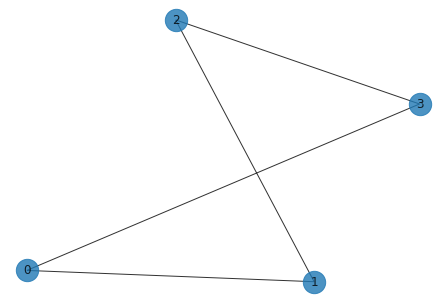

In [66]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])

N = 4
p = 2
edges = nx.edge_betweenness(G).keys()

nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [6]:
## Set everything up and show the graph
#N = 12
#seed = 43
#G = nx.random_regular_graph(d=3, n=N, seed=seed)
#nx.draw(G)

In [67]:
H = np.array(list(product([1, -1], repeat=N))) 
def H_C():
    tmp = np.zeros(2**N)
    for i, j in edges:
        tmp += H[:, i] * H[:, j]
    return tmp

# Find Initial Value By Simulating TQA

In [11]:
# Loop over different evolution times
time = np.linspace(0.1, 4, 50)
energy_expectation_value = get_expectation(G, shots=512)

energies = []
for p in [3, 4]:
    energy = []
    for t_max in time: 
        
        dt = t_max / p
        t = dt * (np.arange(1, p + 1) - 0.5)
        gamma = (t / t_max) * dt
        beta = (1 - (t / t_max)) * dt
        x = np.concatenate((beta, gamma))
        energy.append(energy_expectation_value(x))

    energies.append(energy)

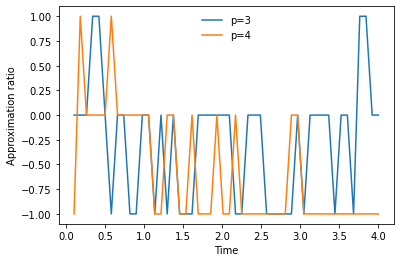

In [12]:
plt.plot(time, energies[0]/min(H_C()), label="p=3")
plt.plot(time, energies[1]/min(H_C()), label="p=4")
plt.xlabel('Time')
plt.ylabel('Approximation ratio')
plt.legend(frameon=False)

In [13]:
# Find optimal time 
idx = np.argmin(energies[1])
t_max = time[idx]
print(f'Optimal evolution time is {t_max} with an approximation ratio of {energies[1][idx]/min(H_C())}')

Optimal evolution time is 0.17959183673469387 with an approximation ratio of 1.0


## Note
We tried to use the code from what you've seen to get the optimal evolution time.
However, it is not usable nor correct, thus we use the same process as the code from TQAinit.ipynb, then get the optimal evolution time from it.

In [43]:
t_max = 2.973684210526316

# Execute The QAOA

In [85]:
expectation = get_expectation(G)

res1 = minimize(expectation, 
                      np.concatenate((np.random.uniform(-np.pi/4, np.pi/4, p), np.random.uniform(-np.pi/2, np.pi/2, p))), 
                      method='BFGS')
res1

      fun: 0.0
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 5
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.02729822, 0.77523389, 0.45448539, 0.23737106])

In [86]:
print(f'Final approximation ratio from random init. is {res1.fun/min(H_C())}')

Final approximation ratio from random init. is -0.0


In [79]:
dt = t_max / p
t = dt * (np.arange(1, p + 1) - 0.5)
gamma = (t / t_max) * dt
beta = (1 - (t / t_max)) * dt
x0 = np.concatenate((beta, gamma))

In [80]:
from scipy.optimize import minimize

expectation = get_expectation(G)

res2 = minimize(expectation, 
                      x0, 
                      method='COBYLA')
res2

     fun: -3.999999999999999
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 42
  status: 1
 success: True
       x: array([1.35697671, 0.2466389 , 0.37165533, 1.05193401])

In [81]:
print(f'Final approximation ratio from TQA init. is {res2.fun/min(H_C())}')

Final approximation ratio from TQA init. is 0.9999999999999998


### Analyzing the result

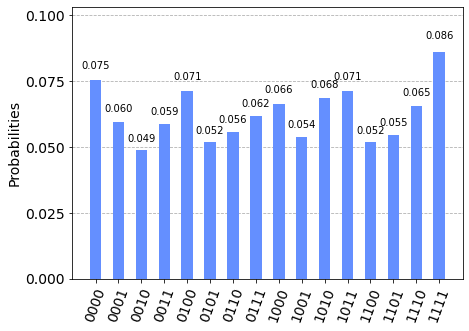

In [87]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res1.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

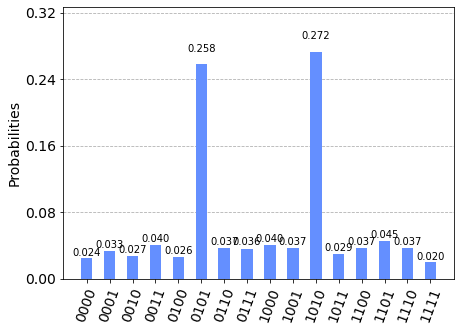

In [83]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res2.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

As we notice that the bitstrings "0101" and "1010" have the highest probability and are indeed the assignments of the graph (we started with) that gives 4 edges between the two partitions. 

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table